In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random
import argparse
from collections import OrderedDict
from copy import copy
import scipy
import scipy.linalg
import os
import math
os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"
# Franka simulator
import sys
sys.path.append("../franka")
sys.path.append("../utility")
sys.path.append("../")
from Utility import DerivativeLiftFunc, data_collecter
import lqr
# physics engine
import pybullet as pb
import pybullet_data
from franka_env import FrankaEnv
from scipy.io import loadmat, savemat

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
pybullet build time: Jan 29 2025 23:20:52


In [2]:
class LSFunc():
    def __init__(self,env_name,Nstate,udim,Nrbf,observation_space, X, Y, U) -> None:
        self.env_name = env_name
        self.Nstate = Nstate
        self.udim = udim        
        self.Nrbf = Nrbf
        self.NKoopman = self.Nstate+self.Nrbf
        lift_val = 4
        self.lift_low = np.clip(observation_space.low,-lift_val,lift_val)
        self.lift_high = np.clip(observation_space.high,-lift_val,lift_val)
        self.type = type
        self.A = None
        self.B = None
        self.learn_LS(X,Y,U)


    def learn_LS(self, X, Y, U):
        """
        最小二乘求解LDS的状态矩阵A和控制矩阵B
        公式：[A_ls, B_ls] = Y @ pinv([X; U])
        """
        N_states = X.shape[0]
        N_control = U.shape[0]
        
        # 构造设计矩阵：纵向拼接状态X和控制U
        design_mat = np.vstack((X, U))
        
        #  Moore-Penrose逆求解最小二乘
        AB_ls = Y @ scipy.linalg.pinv(design_mat)
        A_ls = AB_ls[:, :N_states]  # 前N_states列是状态矩阵A
        B_ls = AB_ls[:, N_states:]  # 后N_control列是控制矩阵B
        
        # 验证稳定性：计算谱半径（最大特征值的模）
        eig_ls = scipy.linalg.eigvals(A_ls)
        rho_ls = max(np.abs(eig_ls))
        print(f"LS方法：A_ls谱半径 = {rho_ls:.4f}（>1则不稳定）")
        
        # 保存LS参数
        np.savez("Results/LS_Params.npz", A_ls=A_ls, B_ls=B_ls, rho_ls=rho_ls)
        self.A = A_ls
        self.B = B_ls
            
    def Psi_s(self,s):
        #s (N,Nstate)
        s = s.reshape(-1,self.Nstate)
        N,_ = s.shape
        psi = np.zeros([N,self.Nstate])
        psi[:,:self.Nstate] = s  
        return psi  

    def Psi_su(self,s,u):
        s = s.reshape(-1,self.Nstate)
        u = u.reshape(-1,self.udim)
        N,_ = s.shape
        psi = np.zeros([N,self.Nstate+self.udim])
        psi[:,:self.Nstate] = self.Psi_s(s)
        psi[:,self.Nstate:] = u
        return psi


In [3]:
Methods = ["KoopmanDerivative","KoopmanRBF",\
            "KNonlinear","KNonlinearRNN","KoopmanU",\
            "KoopmanNonlinearA","KoopmanNonlinear",\
                ]
method_index = 1
# suffix = "CartPole1_26"
# env_name = "CartPole-v1"
# suffix = "Pendulum1_26"
# env_name = "Pendulum-v1"
# suffix = "DampingPendulum1_26"
# env_name = "DampingPendulum"
# suffix = "MountainCarContinuous1_26"
# env_name = "MountainCarContinuous-v0"
env_name = "Franka"

In [4]:
Data_collecter = data_collecter(env_name)
samples = 1
steps = 1000
Nstate = Data_collecter.Nstates
udim = Data_collecter.udim
Nrbf = 10
train_data = Data_collecter.collect_koopman_data(samples,steps)
X = train_data[:steps,:,udim:].reshape(-1, Nstate)
U = train_data[:steps,:,:udim].reshape(-1, udim)
Y = train_data[1:steps+1,:,udim:].reshape(-1,Nstate)
X = X.T
Y = Y.T
U = U.T
print(X.shape, U.shape)
LiftFunc = LSFunc(env_name,Nstate,udim,Nrbf,Data_collecter.observation_space,X,Y,U)
NKoopman = LiftFunc.NKoopman

b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
panda_link0b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
panda_link1b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
panda_link2b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfIm

100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

(17, 1000) (7, 1000)
LS方法：A_ls谱半径 = 1.0000（>1则不稳定）


In [5]:
simFranka = False # whether to open Graphical interface to animate Franka motion
np.set_printoptions(precision=3)
nStates = 10
accuracy_invKin = 0.000001
def quat_to_euler(q):
    """ 
    Function that converts quaternions to Euler angles
    
    Inputs
    ------
    q : quaternions
    
    Outputs
    -------
    
    phi, theta, psi : Euler angles
    """
    pi = math.pi
    q0, q1, q2, q3 = q[3], q[0], q[1], q[2]
    test = np.dot(q0,q2) - np.dot(q1,q3)
    if (test > 0.4999): 
        phi = math.atan2(q1*q2 - q0*q3, q1*q3 + q0*q2)
        theta = pi/2
        psi= 0
    elif (test < -0.4999):
        phi = math.atan2(- q1*q2 + q0*q3, - q1*q3 - q0*q2)
        theta = -pi/2
        psi = 0
    else:
        sqx = q1*q1
        sqy = q2*q2
        sqz = q3*q3
        
        psi = math.atan2(2*q2*q1+2*q0*q3 , 1 - 2*sqy - 2*sqz) # Yaw
        theta = math.asin(2*test) # Pitch
        phi = math.atan2(2*q2*q3+2*q0*q1 , 1 - 2*sqx - 2*sqy) # Roll
    return phi, theta, psi

def Psi_x(x): 
    return x

def Run_Franka(Steps, state_desired, LQR_gains, x0 = None, y0 = None, z0 = None):
    """
    Function that simulates forward the dynamics of Franka using LQR control, 
    given a desired trajectory and LQR gains
    
    Inputs
    ------
    Steps : Number of steps to propagate discrete dynamics into the future
    state_desired: desired trajectory to track (used for the applied control)
    LQR_gains: LQR gains used together with the current state and desired trajectory 
            to compute control response
            
    Outputs
    -------
    state_traj : state trajectory of the controlled system
    control_traj : control trajectory that was applied to the system
    """
    state = env.reset()
    
    # Set state to desired state to help initiation
    for i, jnt in enumerate(state_desired[0,3:9]):
            pb.resetJointState(env.robot, i, jnt)
    
    # set initial y,z states to given y0, z0
    if x0:
        JointAngles_Fig8 = accurateCalculateInverseKinematics(env.robot, env.ee_id, [x0, y0, z0], accuracy_invKin, 10000)
        for i, jnt in enumerate(JointAngles_Fig8[0:6]):
            pb.resetJointState(env.robot, i, jnt)

    state = env.get_state()

    # Initialize states and controls trajectories
    state_traj, control_traj = np.empty((Steps+1,17)), np.empty((Steps, 7))
    state_traj[:], control_traj[:] = np.NaN,  np.NaN
    
    # Simulate dynamics forward
    for t in range(Steps):
        state = np.append(state[0:3], state[7:])
        state = LiftFunc.Psi_s(state).reshape(Nstate,1)
        state_traj[t, :] = state[:17].reshape(-1)
        
        control = - np.dot(LQR_gains, (state - LiftFunc.Psi_s(state_desired[t+1,:]).reshape(Nstate,1)))
        control_traj[t, :] = control.reshape(-1)
        state = env.step(control)
#         time.sleep(1.0/6000.)
#         time.sleep(1.0/600000.)
    
    state = np.append(state[0:3], state[7:])
    state = LiftFunc.Psi_s(state).reshape(Nstate,1)
    state_traj[t+1, :] = state[:17].reshape(-1)
    return state_traj, control_traj

def accurateCalculateInverseKinematics(kukaId, endEffectorId, targetPos, threshold, maxIter):
    """
    Calculates the joint poses given the End Effector location using inverse kinematics
    Note: It changes the Franka configuration during the optimization to the desired configuration
    
    Input: 
    kukaId : Object that represents the Franka system
    endEffectorId : 
    targetPos : 
    threshold : accuracy threshold
    maxIter : maximum iterations to fine tune solution
    
    Output: 
    jointPoses: The angles of the 7 joints of the Franka 
    """
    numJoints = 7
    closeEnough = False
    iter = 0
    dist2 = 1e30
    while (not closeEnough and iter < maxIter):
        jointPoses = pb.calculateInverseKinematics(kukaId, endEffectorId, targetPos)
    
        for i in range(numJoints):
            pb.resetJointState(kukaId, i, jointPoses[i])
        ls = pb.getLinkState(kukaId, endEffectorId)
        newPos = ls[4]
        diff = [targetPos[0] - newPos[0], targetPos[1] - newPos[1], targetPos[2] - newPos[2]]
        dist2 = (diff[0] * diff[0] + diff[1] * diff[1] + diff[2] * diff[2])
        closeEnough = (dist2 < threshold)
        iter = iter + 1
    return jointPoses[:7]

def runLQRonFranka(steps, desired_target, LQR_gains, x0 = None, y0 = None, z0 = None, method = False):
    """
    Executes a simulation of specified number of steps applying LQR on Franka with the input LQR gains
        
    Inputs
    ------
    steps : number of steps to forward simulate the system
    desired_target : desired_trajectory to track
    LQR_gains : LQR gains used to compute control
    method : method to print on pdf label; if none is specified, no pdf is created
"""
    state_traj, controls_traj = Run_Franka(steps, desired_target, LQR_gains, x0, y0, z0)

    error = np.linalg.norm(state_traj[:,:nStates] - desired_target[:,:nStates])
    if method:
        fig = plt.plot(state_traj[:,1], state_traj[:,2], 'b-', linewidth = 1, markersize = 1)
        plt.plot(desired_target[:,1], desired_target[:,2], 'k--', linewidth = 1)
        plt.axis('equal')
        plt.title(method +': Error = {0:.2f}'.format(error), fontdict=None, loc='center', pad=None)
    return state_traj, controls_traj, error

def desiredStates_from_EndEffector(xyzEndEffector):
    """
    This function takes in the x,y,z coordinates of the end effector (EE) of Franka 
    and returns the closest (locally, using Inverse Kinematics) desired configuration
    to achieve that EE position . 
    
    Inputs
    ------
    x_d, y_d, z_d: End effector coordinates
    
    Outputs
    desired_states: x, y, z, JointAngles, Joint Velocities
    """
    x_d, y_d, z_d = xyzEndEffector[0], xyzEndEffector[1], xyzEndEffector[2]
    jointAngles = np.asarray(accurateCalculateInverseKinematics(env.robot, env.ee_id, [x_d, y_d, z_d], accuracy_invKin, 10000))
    state_des = np.concatenate((xyzEndEffector, jointAngles, np.zeros(7)))

    return state_des

In [6]:
# initialize Franka object
env = FrankaEnv(render = simFranka)

b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
panda_link0b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
panda_link1b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
panda_link2b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfIm

Text(0, 0.5, 'z (m)')

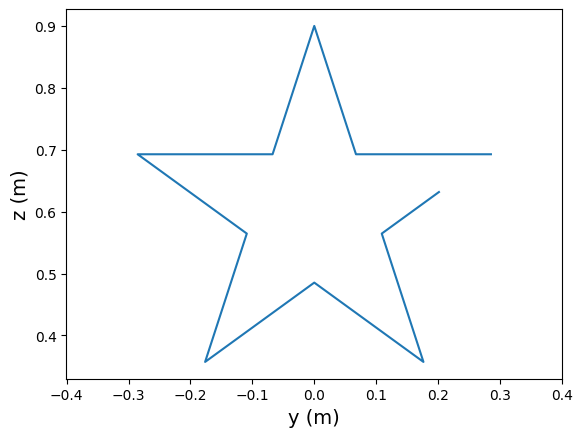

In [7]:
center = np.array([0.0,0.6])
radius = 0.3
theta_ = np.pi/10.0
eradius = np.tan(2*theta_)*radius*np.cos(theta_)-radius*np.sin(theta_) 
Star_points = np.zeros((11,2))
for i in range(5):
    theta = 2*np.pi/5*(i+0.25)
    Star_points[2*i,0] = np.cos(theta)*radius+center[0]
    Star_points[2*i,1] = np.sin(theta)*radius+center[1]
    beta = 2*np.pi/5*(i+0.75)
    Star_points[2*i+1,0] = np.cos(beta)*eradius+center[0]
    Star_points[2*i+1,1] = np.sin(beta)*eradius+center[1]    
Star_points[-1,:] = Star_points[0,:]
T = 6 *10 # time horizon 
t = 0.02*np.linspace(0, T*5, T*50+1) # time steps
refs = np.zeros((len(t),2))
Steps = len(t)-1
each_num = int((len(t)-10)/9.5)
for i in range(10):
    refs[(each_num+1)*i,:] = Star_points[i,:]
    if i!= 9:
        num = each_num
    else:
        num = len(t)-(each_num+1)*i-1
    for j in range(num):
        t_ = (j+1)/(each_num+1)
        refs[(each_num+1)*i+j+1,:] =  t_*Star_points[i+1,:] + (1-t_)*Star_points[i,:]
# print(each_num,each_num*10.5)
# print(t.shape)
# plt.plot(Star_points[:,0],Star_points[:,1])
x = 0.3*np.ones((len(t),1)) 
z = refs[:,1].reshape(-1,1)
y =  refs[:,0].reshape(-1,1)
plt.plot(y,z)
plt.axis('equal')
plt.xlabel('y (m)', fontsize = 14)
plt.ylabel('z (m)', fontsize = 14)

In [8]:
# Translate desired y-z coordinates to desired joint angles of the Franka robotic arm
JointAngles_Fig8 = np.empty((len(t),7))
JointAngles_Fig8[:] = np.NaN
for i in range(len(t)):
    JointAngles_Fig8[i,:] = accurateCalculateInverseKinematics(env.robot, env.ee_id, [x[i], y[i], z[i]], accuracy_invKin, 10000)
states_des = np.concatenate( (x, y, z, JointAngles_Fig8, np.zeros((len(y), 7))), axis = 1)
# states_des = np.concatenate((x,y,z), axis = 1)


In [9]:
##LQR
import lqr
import time
Ad = LiftFunc.A
Bd = LiftFunc.B
Ad = np.matrix(Ad)
Bd = np.matrix(Bd)
Q = np.zeros((Nstate,Nstate))
Q[:10,:10] = np.eye(10)
R = 0.1*np.eye(7)
Q = np.matrix(Q)
R = np.matrix(R)
Kopt = lqr.lqr_regulator_k(Ad,Bd,Q,R)
print(Kopt.shape)

(7, 17)


In [10]:
np.random.seed(98)
a = [0.01,0.021,-0.015,-0.012,0.093,0.058,0.014,-0.086,-0.096,0.056]
b = [0.043,0.009,0.029,0.078,-0.023,0.006,0.085,-0.083,0.067,0.074]
for i in range(10):
    y0, z0 = y[0,0] + a[i], z[0,0] + b[i]
    state_traj_LS, controls_traj_LS, error_LS = runLQRonFranka(Steps, states_des, Kopt, x[0,0], y0, z0)
    savemat('Results/LSFrankaFigStar_SimData'+str(i)+'.mat', {'desired_states':states_des,'states_LS': state_traj_LS, 'u_LS' : controls_traj_LS,
                                                    'error_LS':error_LS}) # save variables to Matlab file

error error_LS:[[530.345]]


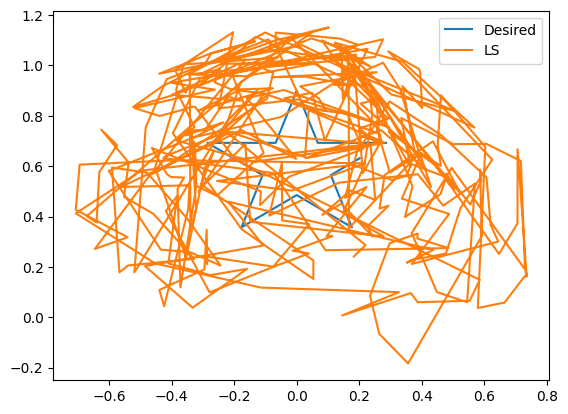

In [11]:
trajs = loadmat('Results/LSFrankaFigStar_SimData0.mat')
state_traj_LS = trajs['states_LS']
desired_traj = trajs['desired_states']
plt.plot(desired_traj[:,1],desired_traj[:,2],label='Desired')
plt.plot(state_traj_LS[:,1],state_traj_LS[:,2],label='LS')
print("error error_LS:{}".format(trajs['error_LS']))
plt.legend()
plt.show()

Text(0, 0.5, 'z (m)')

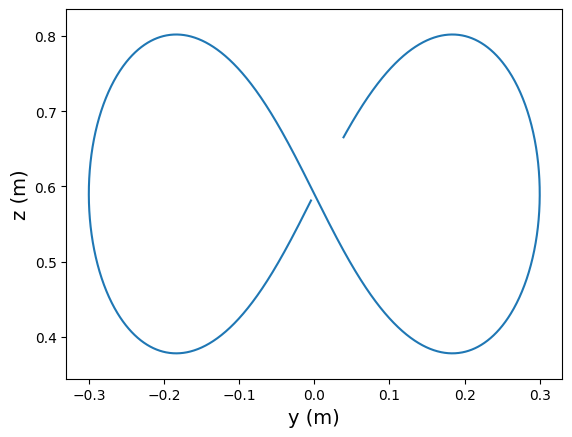

In [12]:
env.reset()
T = 6 *10 # time horizon 
t = 1.6 + 0.02*np.linspace(0, T*5, T*50+1) # time steps
Steps = len(t)-1


a = 0.3 # scaling parameter of Fig. 8 area
x = 0.3*np.ones((len(t),1)) 
z = np.expand_dims(0.59 + 2* a * np.sin(t) * np.cos(t) / (1+np.sin(t)**2), axis = 1)
y = np.expand_dims(a * np.cos(t) / (1+np.sin(t)**2), axis = 1)
plt.plot(y,z)
plt.axis('equal')
plt.xlabel('y (m)', fontsize = 14)
plt.ylabel('z (m)', fontsize = 14)

In [13]:
# Translate desired y-z coordinates to desired joint angles of the Franka robotic arm
JointAngles_Fig8 = np.empty((len(t),7))
JointAngles_Fig8[:] = np.NaN
for i in range(len(t)):
    JointAngles_Fig8[i,:] = accurateCalculateInverseKinematics(env.robot, env.ee_id, [x[i], y[i], z[i]], accuracy_invKin, 10000)
states_des = np.concatenate( (x, y, z, JointAngles_Fig8, np.zeros((len(y), 7))), axis = 1)
# states_des = np.concatenate((x,y,z), axis = 1)


In [14]:
np.random.seed(0)
a = [0.01,0.021,-0.015,-0.012,0.093,0.058,0.014,-0.086,-0.096,0.056]
b = [0.043,0.009,0.029,0.078,-0.023,0.006,0.085,-0.083,0.067,0.074]
for i in range(10):
    y0, z0 = y[0,0] + a[i], z[0,0] + b[i]
    state_traj_LS, controls_traj_LS, error_LS = runLQRonFranka(Steps, states_des, Kopt, x[0,0], y0, z0)
    savemat('Results/LSFrankaFig8_SimData'+str(i)+'.mat', {'desired_states':states_des,'states_LS': state_traj_LS, 'u_LS' : controls_traj_LS,
                                                    'error_LS':error_LS}) # save variables to Matlab file

error error_LS:[[228.606]]


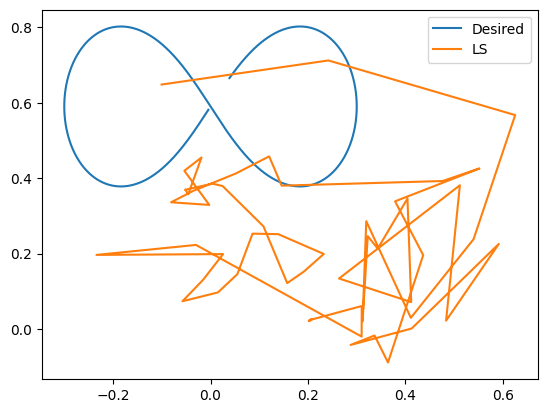

In [15]:
trajs = loadmat('Results/LSFrankaFig8_SimData8.mat')
state_traj_LS = trajs['states_LS']
desired_traj = trajs['desired_states']
plt.plot(desired_traj[:,1],desired_traj[:,2],label='Desired')
plt.plot(state_traj_LS[:,1],state_traj_LS[:,2],label='LS')
print("error error_LS:{}".format(trajs['error_LS']))
plt.legend()
plt.show()